# Model for NIST database uppercase characters
    - Model with the roposed architecture over the uppercase characters of NIST database
    - Use hsf_4 as test dataset.

In [1]:
import numpy as np
import pandas as pd
#import cv2

from scipy.misc import imresize, imrotate, imsave 


import matplotlib.pyplot as plt

# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'              # use grayscale output color heatmap


In [5]:
#Read NIST database
path_NIST='/home/jorge/data/tesis/handwriting/databases/NIST/by_class/'

char_list_lo = ['41','42','43','44','45','46','47','48','49','4a','4b','4c','4d',
                '4e','4f','50','51','52','53','54','55','56','57','58','59','5a']

decode_lo={}
encode_lo={}
for i , c in enumerate(char_list_lo):
    char = str(unichr(int(c,16)))
    decode_lo[i] = char
    encode_lo[char] = i
print decode_lo              

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [6]:
# Generator of list of files in a folder and subfolders
import os
import shutil
import fnmatch

def gen_find(filepat,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepat):
            yield os.path.join(path,name)

In [7]:

#Read train dataset
X_trn=[]
y_trn=[]
for char in char_list_lo:
    letter = str(unichr(int(char,16)))
    images_list = gen_find("*.png", path_NIST+char+'/train_'+char) 
    for img_name in images_list:
        img = plt.imread(img_name)
        
        #Transform
        img = img[32:96,32:96,0]
        
        X_trn += [img]
        y_trn += [encode_lo[letter]]

X_trn = 1. - np.array(X_trn)
y_trn = np.array(y_trn)
        
print(X_trn.shape)
print(y_trn.shape)

(208363, 64, 64)
(208363,)


In [8]:
hsf='/hsf_4/'

#Read test dataset
X_tst=[]
y_tst=[]
for char in char_list_lo:
    letter = str(unichr(int(char,16)))
    images_list = gen_find("*.png", path_NIST+char+hsf) 
    for img_name in images_list:
        img = plt.imread(img_name)
        
        #Transform
        img = img[32:96,32:96,0]
        
        X_tst += [img]
        y_tst += [encode_lo[letter]]

X_tst = 1. - np.array(X_tst)
y_tst = np.array(y_tst)
        
print(X_tst.shape)
print(y_tst.shape)

(11941, 64, 64)
(11941,)


In [9]:
X_trn = X_trn.reshape((X_trn.shape[0],1,64,64))
X_tst = X_tst.reshape((X_tst.shape[0],1,64,64))

In [10]:
#
#first model
#

from keras.models import Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import SGD

print('Build model 1...')
input_images = Input(shape=(1, 64, 64))

c11 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(input_images)
c12 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(c11)
c1_mp = MaxPooling2D((2, 2))(c12)

c21 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(c1_mp)
c22 = Convolution2D(128, 3, 3, border_mode='same', activation='relu')(c21)
c2_mp = MaxPooling2D((2, 2))(c22)

c31 = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(c2_mp)
c32 = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(c31)
c33 = Convolution2D(256, 3, 3, border_mode='same', activation='relu')(c32)
c3_mp = MaxPooling2D((2, 2))(c33)

conv_out = Flatten()(c3_mp)

dense1 = Dense(1024, activation='relu')(conv_out)
after_dp1 = Dropout(0.5)(dense1)

dense2 = Dense(1024, activation='relu')(after_dp1)
after_dp2 = Dropout(0.5)(dense2)

output = Dense(26, activation='softmax')(after_dp2)

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Build model 1...


In [ ]:
#Data augmentation in keras
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 15,       # 15º of random rotation
    width_shift_range = 0.20,  # 20% of random translation width
    height_shift_range = 0.20, # 20% of random translation height
    shear_range = 0.15,        # 5º of shear
    zoom_range = 0.20)         # +- 20% of zoom 



In [ ]:
# Create the model
model_l = Model(input=input_images, output=output)

#Fit model  on batches with real-time data augmentation:
sgd = SGD(lr=0.01, decay=0.001, momentum=0.9, nesterov=True)
model_l.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

hist_l_1 = model_l.fit_generator(datagen.flow(X_trn, y_trn, batch_size=128),
                    samples_per_epoch=len(X_trn), nb_epoch=20, 
                    validation_data=(X_tst, y_tst))

print 'Done!'

Epoch 1/20
208363/208363 [==============================] - 711s - loss: 1.1297 - acc: 0.6709 - val_loss: 0.1758 - val_acc: 0.9487
Epoch 2/20
208363/208363 [==============================] - 716s - loss: 0.3352 - acc: 0.9045 - val_loss: 0.1235 - val_acc: 0.9631
Epoch 3/20
208363/208363 [==============================] - 717s - loss: 0.2700 - acc: 0.9237 - val_loss: 0.1146 - val_acc: 0.9659
Epoch 4/20
208363/208363 [==============================] - 716s - loss: 0.2377 - acc: 0.9331 - val_loss: 0.1074 - val_acc: 0.9686
Epoch 5/20
208363/208363 [==============================] - 717s - loss: 0.1696 - acc: 0.9529 - val_loss: 0.0893 - val_acc: 0.9735
Epoch 17/20
208363/208363 [==============================] - 716s - loss: 0.1688 - acc: 0.9530 - val_loss: 0.0845 - val_acc: 0.9749
Epoch 18/20
208363/208363 [==============================] - 717s - loss: 0.1657 - acc: 0.9538 - val_loss: 0.0863 - val_acc: 0.9751
Epoch 19/20
208363/208363 [==============================] - 716s - loss: 0.1633 

# Accuracy for NIST database (2nd ed) upper case: 97,3%
    - In the previous version with less iterations we obtained 96.9% (included in the paper)

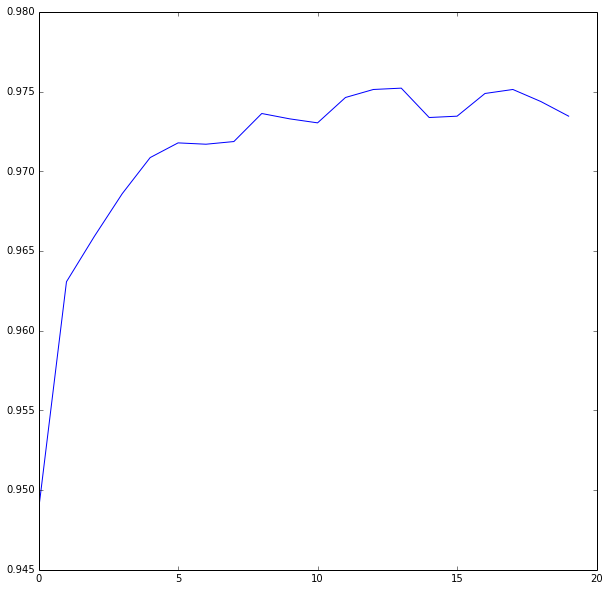

In [13]:
plt.plot(hist_l_1.history['val_acc'])

In [14]:
#Save model
path_models = '/home/jorge/data/tesis/handwriting/p01_read_character/'

model_name = 'nist_uppercase_01'

json_string = model_l.to_json()
open(path_models + 'models/mdl_' + model_name + '.json', 'w').write(json_string)
model_l.save_weights(path_models + 'models/w_' + model_name + '.h5', overwrite=True)

# Save decode_target
#import pickle
#pickle.dump( decode_target_l, open( path_models + "models/unipen_decode_target_lowercase.p", "wb" ) )